# Задача 7. Нейронная сеть

Щека Дмитрий Вадимович, 24.М41

Датасет взял предложенный, не стал выдумывать

Вроде, все поставленные задачи выполнил, так что претендую на 10 баллов

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cpu'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
trainset = torchvision.datasets.SVHN(root='./svhn-dataset', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./svhn-dataset', split='test', download=True, transform=transform)

In [5]:
from torch.utils.data import random_split

val_size = 7000
train_size = len(trainset) - val_size

# Разделение данных
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(FullyConnectedLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weights.t() + self.bias

class ReluLayer(nn.Module):
    def __init__(self):
        super(ReluLayer, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = FullyConnectedLayer(3*32*32, 128)
        self.relu1 = ReluLayer()
        self.fc2 = FullyConnectedLayer(128, 64)
        self.relu2 = ReluLayer()
        self.fc3 = FullyConnectedLayer(64, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

class SimpleNNBatchNorm(nn.Module):
    def __init__(self):
        super(SimpleNNBatchNorm, self).__init__()
        self.fc1 = FullyConnectedLayer(3*32*32, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.fc2 = FullyConnectedLayer(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.fc3 = FullyConnectedLayer(64, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * param.data

            self.m[i] = beta1 * self.m[i] + (1 - beta1) * grad
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (grad ** 2)

            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)

            param.data = param.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()


def get_optimizer(name, params, lr):
    if name == 'adam':
        return AdamOptimizer(params, lr=lr)
    elif name == 'momentum':
        return optim.SGD(params, lr=lr, momentum=0.9)
    else:
        raise ValueError("Unknown optimizer: {}".format(name))

In [7]:
def validate_gradients(model, inputs, targets, criterion, delta=1e-5):
    inputs = inputs.view(-1, 3*32*32).to(device)
    targets = targets.to(device)
    model.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()

    param_list = [param for param in model.parameters() if param.requires_grad]
    total_params = sum(p.numel() for p in param_list)
    num_checks = 15
    if num_checks > total_params:
        num_checks = total_params

    selected_indices = torch.randperm(total_params)[:num_checks]

    for param in param_list:
        print(f"Validating gradient for parameter: {param.shape}")
        param_data_flat = param.data.view(-1)
        param_grad_flat = param.grad.view(-1)

        for idx in selected_indices:
            if idx >= param_data_flat.size(0):
                break

            original_value = param_data_flat[idx].item()
            param_data_flat[idx] = original_value + delta
            loss_plus = criterion(model(inputs), targets).item()
            param_data_flat[idx] = original_value - delta
            loss_minus = criterion(model(inputs), targets).item()
            param_data_flat[idx] = original_value

            estimated_grad = (loss_plus - loss_minus) / (2 * delta)
            actual_grad = param_grad_flat[idx].item()

            if abs(estimated_grad - actual_grad) > delta:
                print(f'Gradient check failed for parameter at index {idx}')
                return False

    print('All gradients are correct!')
    return True


In [8]:
def train_model(model, trainloader, valloader, criterion, optimizer, epochs=10):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        train_loss.append(running_loss/len(trainloader))

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        val_loss.append(val_running_loss/len(valloader))

        validate_gradients(model, *next(iter(trainloader)), criterion)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")

    return train_loss, val_loss

Training SimpleNN with learning rate 0.001 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 339970
Epoch 1/10, Train Loss: 1.3850828630698693, Val Loss: 0.9801687105135484
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 150612
Epoch 2/10, Train Loss: 0.8881481402341463, Val Loss: 0.8169363593513316
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 318319
Epoch 3/10, Train Loss: 0.75125122872904, Val Loss: 0.7278426622802561
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 385363
Epoch 4/10, Train Loss: 0.6780983725109616, Val Loss: 0.6936695144935088
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 115111
Epoch 5/10, Train Loss: 0.6228454944940147, Val Loss: 0.6655966541983864
Validating gradient 

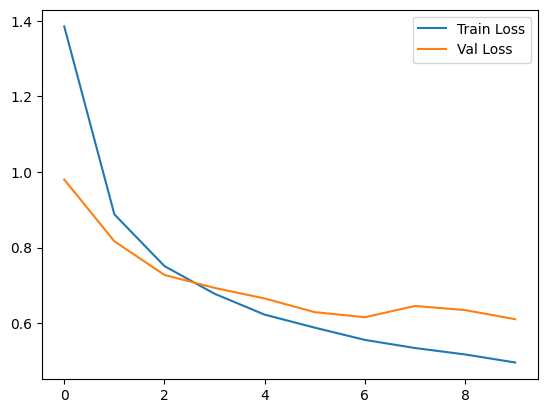

Training SimpleNN with learning rate 0.001 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 214271
Epoch 1/10, Train Loss: 2.262030002003011, Val Loss: 2.243051832372492
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 326472
Epoch 2/10, Train Loss: 2.2381750614486604, Val Loss: 2.2378044258464467
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 69655
Epoch 3/10, Train Loss: 2.235814716825154, Val Loss: 2.237338796528903
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 385089
Epoch 4/10, Train Loss: 2.234661950107707, Val Loss: 2.236808646808971
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 317019
Epoch 5/10, Train Loss: 2.2301886912478444, Val Loss: 2.225740809874101
Validating gradient fo

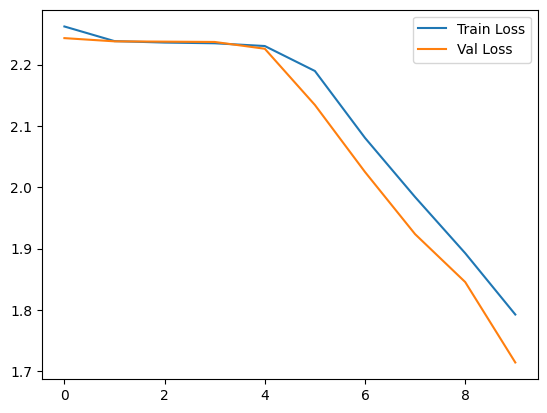

Training SimpleNN with learning rate 0.01 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 293260
Epoch 1/10, Train Loss: 2.081078694133685, Val Loss: 1.9975606885823336
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 274515
Epoch 2/10, Train Loss: 1.988458782089263, Val Loss: 2.0136390469290992
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 350613
Epoch 3/10, Train Loss: 1.957758011620017, Val Loss: 1.95845731605183
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 70164
Epoch 4/10, Train Loss: 1.9155331252854764, Val Loss: 1.8776284250346098
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 31789
Epoch 5/10, Train Loss: 1.9047961099267465, Val Loss: 1.8868477496233853
Validating gradient for pa

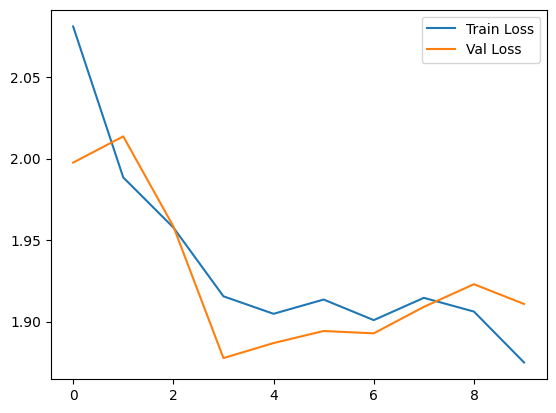

Training SimpleNN with learning rate 0.01 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 233584
Epoch 1/10, Train Loss: 2.155864782660164, Val Loss: 1.7811512719501148
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 1.3894544840434344, Val Loss: 1.0877222288738597
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 258400
Epoch 3/10, Train Loss: 0.9606452781318697, Val Loss: 0.8877696075222709
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 18335
Epoch 4/10, Train Loss: 0.791

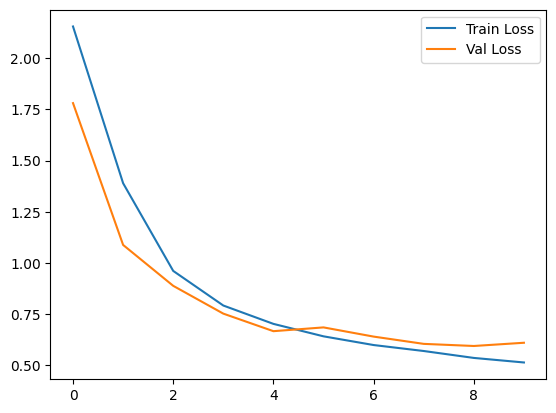

Training SimpleNN with learning rate 0.001 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 146251
Epoch 1/10, Train Loss: 1.42243780161193, Val Loss: 0.9829855951395902
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 212077
Epoch 2/10, Train Loss: 0.9097714864839458, Val Loss: 0.8415851037610661
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 186857
Epoch 3/10, Train Loss: 0.7727172959265102, Val Loss: 0.7544000208377838
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 32533
Epoch 4/10, Train Loss: 0.7003604908362319, Val Loss: 0.7175752566619353
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 168838
Epoch 5/10, Train Loss: 0.6434738605524122, Val Loss: 0.6951038821177049
Validating gradient f

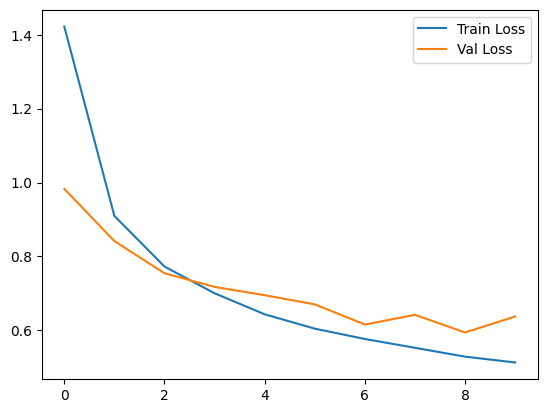

Training SimpleNN with learning rate 0.001 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 219093
Epoch 1/10, Train Loss: 2.261530080817381, Val Loss: 2.2428519118915906
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 131092
Epoch 2/10, Train Loss: 2.2377693231961904, Val Loss: 2.2382931319150057
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 14702
Epoch 3/10, Train Loss: 2.2352290719632477, Val Loss: 2.237664729898626
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 285800
Epoch 4/10, Train Loss: 2.2328296538485524, Val Loss: 2.2314883600581776
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 287127
Epoch 5/10, Train Loss: 2.2151419159068104, Val Loss: 2.18592944578691
Validating gradient

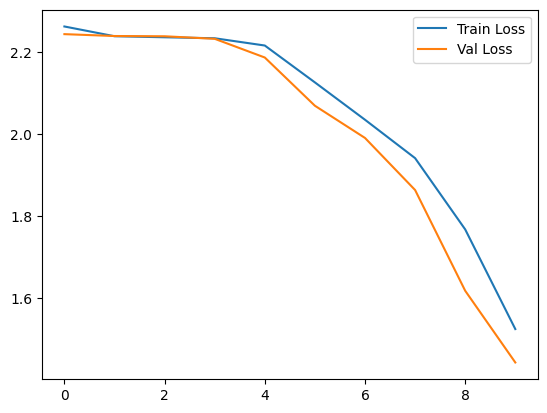

Training SimpleNN with learning rate 0.01 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 128646
Epoch 1/10, Train Loss: 2.2070919194736995, Val Loss: 2.3829621770165184
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 2.1776300662963086, Val Loss: 2.1628117615526374
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 180827
Epoch 3/10, Train Loss: 2.130156623120474, Val Loss: 2.134537946094166
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 12810
Epoch 4/10, Train Loss: 2.11734153

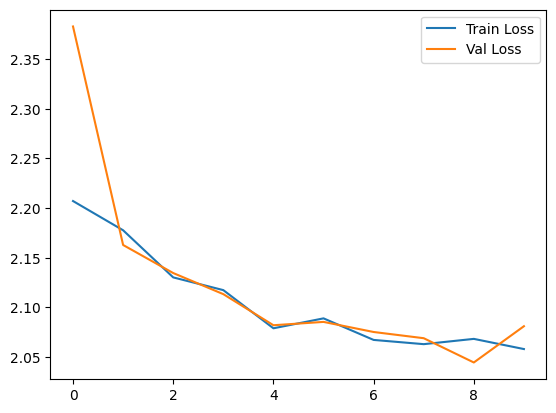

Training SimpleNN with learning rate 0.01 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 65718
Epoch 1/10, Train Loss: 2.178922931199829, Val Loss: 1.976732372153889
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 94311
Epoch 2/10, Train Loss: 1.477850011934645, Val Loss: 1.2462126954035326
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 177787
Epoch 3/10, Train Loss: 0.9698991390326308, Val Loss: 0.8425550699234009
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 375505
Epoch 4/10, Train Loss: 0.7915355436877854, Val Loss: 0.732034568624063
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 119236
Epoch 5/10, Train Loss: 0.7026548620068889, Val Loss: 0.7081574935804714
Validating gradient f

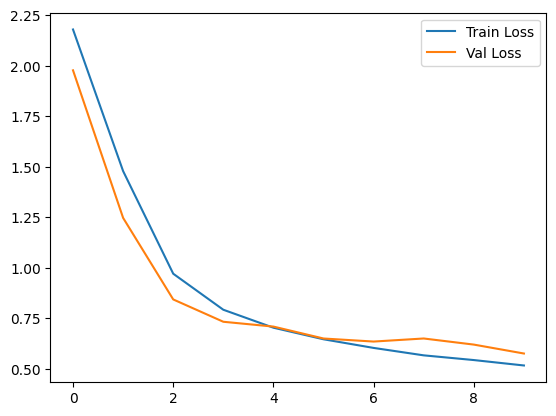

In [9]:
from itertools import product

models = [SimpleNN(), SimpleNNBatchNorm()]
lrs = [0.001, 0.01]
optimizers = ['adam', 'momentum']
results = []

for model, lr, optimizer_name in product(models, lrs, optimizers):
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)

    print(f"Training {model.__class__.__name__} with learning rate {lr} and optimizer {optimizer_name}")
    train_loss, val_loss = train_model(model, trainloader, valloader, criterion, optimizer)
    result = dict()
    result['train_loss'] = train_loss
    result['val_loss'] = val_loss
    result['model'] = model.__class__.__name__
    result['optimizer'] = optimizer_name
    result['lr'] = lr

    results.append(result)

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.show()

In [10]:
min_val_loss = 10
for res in results:
    if res['val_loss'][-1] < min_val_loss:
        min_val_loss = res['val_loss'][-1]

for res in results:
    if res['val_loss'][-1] == min_val_loss:
        print(f'Best combination of params is: Model - {res["model"]}, optimizer - {res["optimizer"]}, lr - {res["lr"]}')
        print(f'Best validation loss after 10 epochs - {min_val_loss}')
        break

Best combination of params is: Model - SimpleNN, optimizer - momentum, lr - 0.01
Best validation loss after 10 epochs - 0.5748376423662359


In [11]:
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = get_optimizer('momentum', model.parameters(), lr=0.01)

train_loss, val_loss = train_model(model, trainloader, valloader, criterion, optimizer, epochs=20)

Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 377160
Epoch 1/20, Train Loss: 2.189115878928122, Val Loss: 1.9857490409504284
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 25583
Epoch 2/20, Train Loss: 1.4715119355778896, Val Loss: 1.1306946429339322
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 22797
Epoch 3/20, Train Loss: 0.9748410902716018, Val Loss: 0.8397024230523543
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 215435
Epoch 4/20, Train Loss: 0.7937210101245913, Val Loss: 0.7999064179984006
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed for parameter at index 168138
Epoch 5/20, Train Loss: 0.7103003485264926, Val Loss: 0.6946714563803239
Validating gradient for parameter: torch.Size([128, 3072])
Gradient check failed fo

In [12]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on test images: {100 * correct / total}%")

evaluate_model(model, testloader)

Accuracy of the model on test images: 77.48540258143824%


### Итог

Наилучшей конфигурацей оказалось: Model - SimpleNN, optimizer - momentum, lr - 0.01. Вышла точность в 77%. Нормально, наверное?..
